<div class="alert alert-block alert-success">
    <b>Artifical Intelligence, Project: Medical Image Classification</b> <br>
Ghent University <br>
AY 2024/2025 <br>
Axelle Petit, Robbe Goeminne, Fien Geukens, Arthur Dhont
</div>

## Task 1: Data exploration, pre-processing and Augmentation

### 1.0. Imports

In [1]:
!pip install pyaml==25.1.0
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import imblearn
import yaml

print("numpy:", np.__version__)
print("tensorflow:", tf.__version__)
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("pyaml:", yaml.__version__)



  Using cached pyaml-25.1.0-py3-none-any.whl.metadata (12 kB)
Using cached pyaml-25.1.0-py3-none-any.whl (26 kB)


2025-04-16 19:28:53.029127: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 88, in _run_code


ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/AI/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/AI/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/AI/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/AI/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/AI/lib/python3.12/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/AI/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/AI/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/

AttributeError: _UFUNC_API not found

ImportError: numpy.core.umath failed to import

<div class="alert alert-block alert-info">
Die versies komen nie overeen me wa er in de opgave staat en idk hoe te fixen

In [5]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

### 1.1. Loading the data

In [9]:
#set the paths/directories
path = Path('covid xray')
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

test_covid_dir = os.path.join(test_dir, 'COVID')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

#### 1.1.1. Set up image generators

In [74]:
#use ImageDataGenerator to read image and transform them into a tensor
train_image_generator = ImageDataGenerator(rescale = 1./255) #RGB data is on scale [0,255] and we want scale [0,1]
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255)

#### 1.1.2. Load as arrays

In [49]:
batch_size = 128
img_height = img_width = 299

In [51]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')
#Flow from directory function: 
#Loads images in batches
#Resizes them to target_size
#Labels them based on the subfolder names.
#Returns an iterator you can use directly in model.fit().

Found 1600 images belonging to 2 classes.


In [53]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary')

Found 400 images belonging to 2 classes.


In [55]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary')

Found 200 images belonging to 2 classes.


### 1.2. Data Exploration

#### 1.2.1 Training dataset Size

In [59]:
# Check how many images you have in training data
num_covid_imgs = len(os.listdir(train_covid_dir))
num_normal_imgs = len(os.listdir(train_normal_dir))

print(f'COVID training images: {num_covid_imgs}')
print(f'NORMAL training images: {num_normal_imgs}')

total_train = num_covid_imgs + num_normal_imgs
print("--")
print(f'Total training images: {total_train}')

COVID training images: 800
NORMAL training images: 800
--
Total training images: 1600


#### 1.2.2. Check whether the images have the same size

In [62]:
#Check for COVID images (training data)
folder = 'covid xray/train/COVID' 
sizes = set() #sets do not allow duplicate values.
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


In [64]:
#Check for NORMAL images (training data)
folder = 'covid xray/train/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


#### 1.2.3. Distribution of two classes

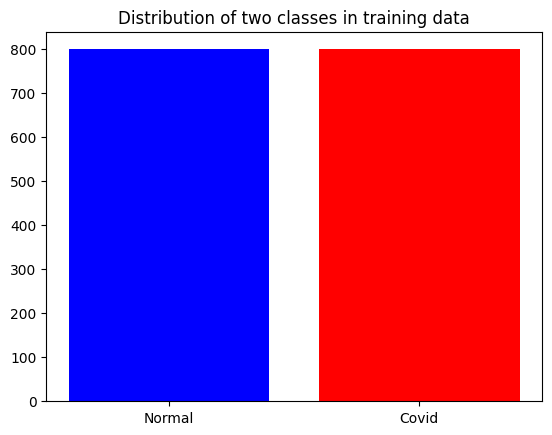

In [67]:
labels = ['Normal', 'Covid']
cases = [num_normal_imgs, num_covid_imgs]  
plt.bar(labels, cases, color=['blue', 'red'])

plt.title('Distribution of two classes in training data')
plt.show()

#### 1.2.4. Visualisation with corresponding label 

In [70]:
print(train_data_gen.class_indices)

{'COVID': 0, 'NORMAL': 1}


In [72]:
#reversing the dict to obtain labels Normal/Covid from values 1/0
i = 0
labels = dict()
for label in train_data_gen.class_indices:
    labels[i] = label
    i+= 1
print(labels)

{0: 'COVID', 1: 'NORMAL'}


In [76]:
sample_training_images, sample_training_labels = next(train_data_gen)
np.unique(sample_training_labels) #checks if there are 2 classes

#train_data_gent = image generator 
#next(train_data_gen) fetches one batch of images and labels.

array([0., 1.], dtype=float32)

In [77]:
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(labels[int(label)], fontsize=14)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

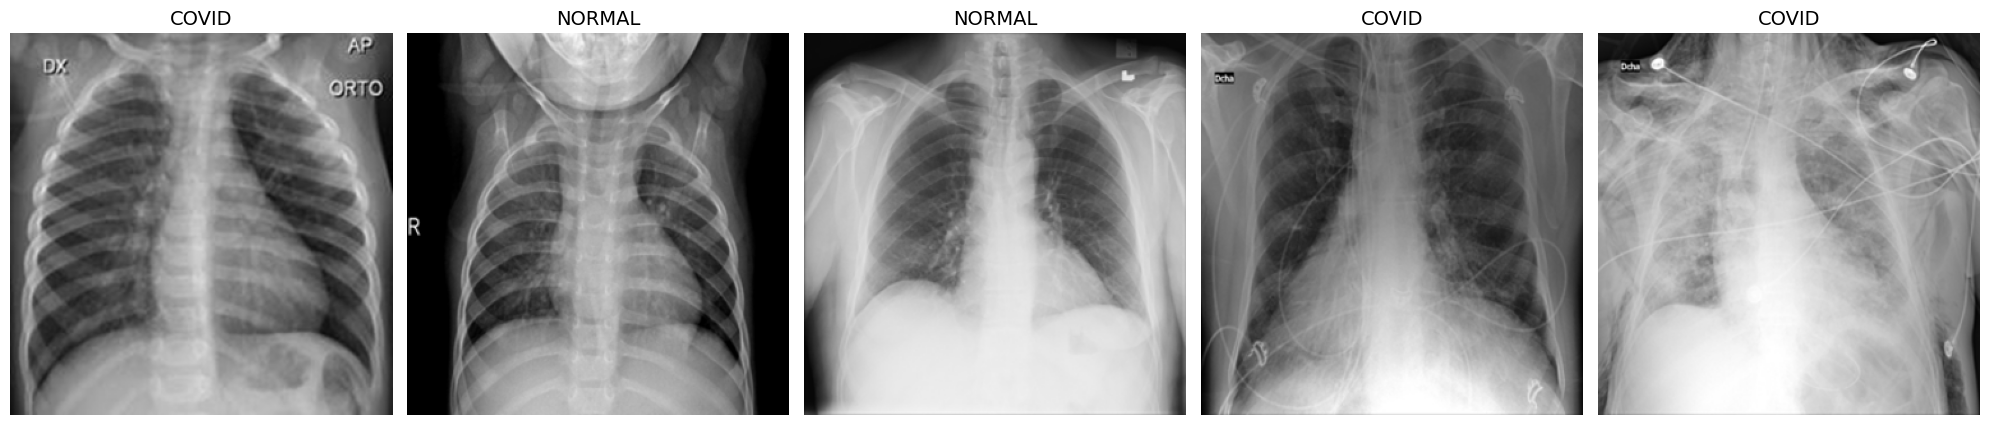

In [80]:
plotImages(sample_training_images[:5], sample_training_labels[:5]) #plots the 5 first images from the batch
#print(sample_training_labels[:5])

#### 1.2.5. Statistics on the pixel intensities

In [83]:
sample_images = sample_training_images[:5]

# sample_images shape: (batch_size, height, width, channels)

# Per-image stats
#For every image (axis 0), calculate the average intensity across all its pixels (axes 1 and 2) and channels (axis 3).
image_means = np.mean(sample_images, axis=(1, 2, 3))  #average intensity over each image
image_stds = np.std(sample_images, axis=(1, 2, 3))    #how much pixel value varies in each image

# Global stats across all pixels in the batch
global_mean = np.mean(sample_images)
global_std = np.std(sample_images)

# Print results
print("=== Per Image Stats ===")
print(f"Pixel Means: {image_means}")
print(f"Pixel STDs: {image_stds}")

print("\n=== Global Stats ===")
print(f"Global Pixel Mean: {global_mean:.4f}")
print(f"Global Pixel Std Dev: {global_std:.4f}")


=== Per Image Stats ===
Pixel Means: [0.46433556 0.37356573 0.621579   0.44712743 0.6662903 ]
Pixel STDs: [0.1751313  0.2581216  0.24192064 0.21152629 0.1923327 ]

=== Global Stats ===
Global Pixel Mean: 0.5146
Global Pixel Std Dev: 0.2445


#### 1.2.6. Repeat steps for validation set

In [86]:
#Check for COVID images (validation data)
folder = 'covid xray/val/COVID' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

#Check for NORMAL images (val data)
folder = 'covid xray/val/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}
Unique image sizes: {(299, 299)}


In [88]:
num_covid_imgs_val = len(os.listdir(validation_covid_dir))
num_normal_imgs_val = len(os.listdir(validation_normal_dir))

print(f'COVID validation images: {num_covid_imgs_val}')
print(f'NORMAL validation images: {num_normal_imgs_val}')

print("--")
total_val = num_covid_imgs_val + num_normal_imgs_val
print(f'Total validation images: {total_val}')

COVID validation images: 200
NORMAL validation images: 200
--
Total validation images: 400


In [90]:
#Check for COVID images (validation data)
folder = 'covid xray/val/COVID' 
sizes = set() #sets do not allow duplicate values.
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


In [92]:
#Check for NORMAL images (validation data)
folder = 'covid xray/val/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


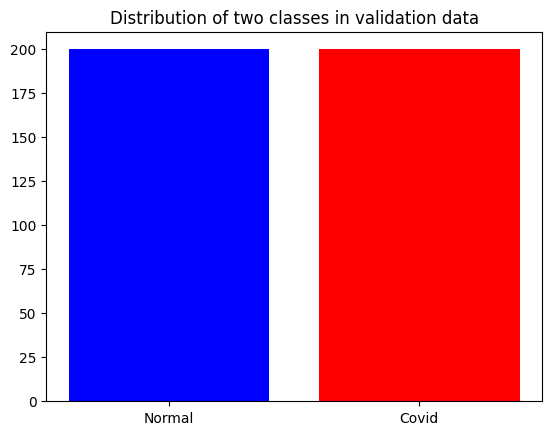

In [94]:
labels = ['Normal', 'Covid']
cases = [num_normal_imgs_val, num_covid_imgs_val]  
plt.bar(labels, cases, color=['blue', 'red'])

plt.title('Distribution of two classes in validation data')
plt.show()

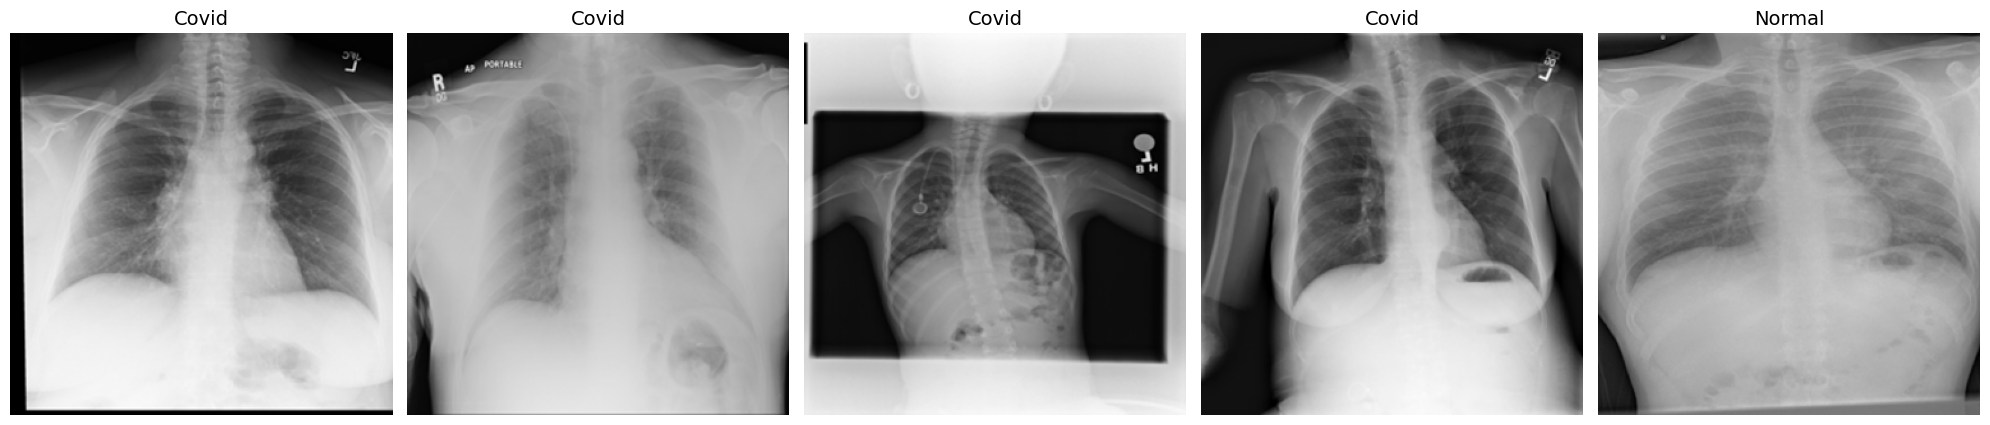

In [96]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
np.unique(sample_validation_labels) 
plotImages(sample_validation_images[:5], sample_validation_labels[:5])

In [97]:
sample_images_val = sample_validation_images[:5]

# sample_images shape: (batch_size, height, width, channels)

# Per-image stats
#For every image (axis 0), calculate the average intensity across all its pixels (axes 1 and 2) and channels (axis 3).
image_means_val = np.mean(sample_images_val, axis=(1, 2, 3))  #average intensity over each image
image_stds_val = np.std(sample_images_val, axis=(1, 2, 3))    #how much pixel value varies in each image

# Global stats across all pixels in the batch
global_mean_val = np.mean(sample_images_val)
global_std_val = np.std(sample_images_val)

# Print results
print("=== Per Image Stats ===")
print(f"Pixel Means: {image_means_val}")
print(f"Pixel STDs: {image_stds_val}")

print("\n=== Global Stats ===")
print(f"Global Pixel Mean: {global_mean_val:.4f}")
print(f"Global Pixel Std Dev: {global_std_val:.4f}")

=== Per Image Stats ===
Pixel Means: [0.60037524 0.6229798  0.5085164  0.472455   0.59257364]
Pixel STDs: [0.29987347 0.1886758  0.3243991  0.28137428 0.14228638]

=== Global Stats ===
Global Pixel Mean: 0.5594
Global Pixel Std Dev: 0.2635


#### 1.2.7. Repeat steps for test set

### 1.3. Pre-processing

## Taks 2: Developing baseline model

## 3. Fine-tuning a pre-trained model

## 4. Evaluating and describing models' performance and behaviour

In [1]:
print('test123')

test123
